# Loan Default Prediction Using Lending Club Loan Data Part 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import time

from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 
from sklearn.grid_search import GridSearchCV 

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

warnings.filterwarnings("ignore")
%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
ls

test_current.csv       test_past_loan.csv      train_past.csv
test_current_loan.csv  train_current.csv       train_past_loan.csv
test_past.csv          train_current_loan.csv  Untitled.ipynb


### load the structured data

In [2]:
test_current = pd.read_csv("test_current.csv")
test_current_loan = pd.read_csv("test_current_loan.csv")
test_past = pd.read_csv("test_past.csv")
test_past_loan = pd.read_csv("test_past_loan.csv")

train_current = pd.read_csv("train_current.csv")
train_current_loan = pd.read_csv("train_current_loan.csv")
train_past = pd.read_csv("train_past.csv")
train_past_loan = pd.read_csv("train_past_loan.csv")

In [3]:
test_current = test_current.iloc[:, 1:]
test_current_loan = test_current_loan.iloc[:, 1:]
test_past = test_past.iloc[:, 1:]
test_past_loan = test_past_loan.iloc[:, 1:]

train_current = train_current.iloc[:, 1:]
train_current_loan = train_current_loan.iloc[:, 1:]
train_past = train_past.iloc[:, 1:]
train_past_loan = train_past_loan.iloc[:, 1:]

### split data into train and test

In [4]:
# split past data to train and test
from sklearn.cross_validation import train_test_split

# Whole dataset
X_train_past, X_test_past, y_train_past, y_test_past = train_test_split(train_past, train_past_loan, test_size = 0.2, random_state = 0)

print("Number past loan train dataset: ", len(X_train_past))
print("Number past loan test dataset: ", len(X_test_past))
print("Total number of past loan dataset: ", len(X_train_past)+len(X_test_past))
print("------------------------------------------------------")
X_train_current, X_test_current, y_train_current, y_test_current = train_test_split(train_current, train_current_loan, test_size = 0.2, random_state = 0)

print("Number current loan train dataset: ", len(X_train_current))
print("Number current loan test dataset: ", len(X_test_current))
print("Total number of current loan dataset: ", len(X_train_current)+len(X_test_current))



Number past loan train dataset:  463490
Number past loan test dataset:  115873
Total number of past loan dataset:  579363
------------------------------------------------------
Number current loan train dataset:  212433
Number current loan test dataset:  53109
Total number of current loan dataset:  265542


### Select a subset of training dataset to decrease training time

In [5]:
# Since it took about 30 minutes to train the model, I decide to try a smaller dataset 1/10 of train dataset
number_train_past = len(X_train_past)
sub_train_past_indices = np.random.choice(X_train_past.index, int(number_train_past/10), replace = False)
sub_train_past_indices = np.array(sub_train_past_indices)

X_sub_train_past = X_train_past.loc[sub_train_past_indices, :]
y_sub_train_past = y_train_past.loc[sub_train_past_indices, :]

print("Number past loan train dataset: ", len(X_sub_train_past))


Number past loan train dataset:  46349


#### logistic regression model on last loan data

In [7]:

t0 = time.time()
lr = LogisticRegression()

lr.fit(X_sub_train_past, y_sub_train_past.loan_status.values.ravel())

y_test_past_pred = lr.predict(X_test_past)
t1 = time.time()
y_sub_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the logistic regression model".format(t1 - t0))
print("the auc value of the model test data is: {}".format(y_sub_test_auc))


took 22.602675914764404 seconds to train the logistic regression model
the auc value of the model test data is: 0.7469164227635243


In [9]:
def param_search(X, y, model, param_grid, nfolds):
    gridSearch = GridSearchCV(model, param_grid, scoring='roc_auc', cv=nfolds)
    gridSearch.fit(X, y)
    return gridSearch.best_params_

In [9]:
lr = LogisticRegression()
penalties = ['l1', 'l2']
Cs = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': Cs, 'penalty': penalties}
best_param = param_search(X_sub_train_past, y_sub_train_past.loan_status.values.ravel(), lr, param_grid, 5)
print(best_param)

{'C': 10, 'penalty': 'l1'}


In [10]:
t0 = time.time()
lr = LogisticRegression(C = 10, penalty = 'l1')

lr.fit(X_sub_train_past,y_sub_train_past.loan_status.values.ravel())

y_test_past_pred = lr.predict(X_test_past)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the logistic regression model".format(round(t1 - t0, 3)))
print("the auc value of the logistic regression model on current loan is: {}".format(y_test_auc))

y_ls_test_past_pred = lr.predict(test_past)
#y_test_past_pred.shape
y_ls_test_auc = roc_auc_score(test_past_loan.loan_status.values, y_ls_test_past_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 123.111 seconds to train the logistic regression model
the auc value of the logistic regression model on current loan is: 0.891277308329626
the auc value of the model on 2016 test data is: 0.868


#### support vector machine model on last loan data

In [31]:
t0 = time.time()
svm = SVC()
svm.fit(X_sub_train_past, y_sub_train_past.loan_status.values.ravel())
y_test_past_pred = svm.predict(X_test_past)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the support vector machine model".format(round(t1 - t0, 3)))
print("the auc value of the model on the test data is: {}".format(round(y_test_auc, 3)))

y_ls_test_past_pred = svm.predict(test_past)
#y_test_past_pred.shape
y_ls_test_auc = roc_auc_score(test_past_loan.loan_status.values, y_ls_test_past_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))


took 2480.234 seconds to train the support vector machine model
the auc value of the model on the test data is: 0.5
the auc value of the model on 2016 test data is: 0.5


#### naive bayes model on last loan data

In [30]:
# model with logistic regression model on last loan data

t0 = time.time()
naiveBayes = GaussianNB()
naiveBayes.fit(X_sub_train_past, y_sub_train_past.loan_status.values.ravel())
y_test_past_pred = naiveBayes.predict(X_test_past)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the naive bayes model".format(round(t1 - t0, 3)))
print("the auc value of the model on the test data is: {}".format(round(y_test_auc, 3)))


y_ls_test_past_pred = naiveBayes.predict(test_past)
#y_test_past_pred.shape
y_ls_test_auc = roc_auc_score(test_past_loan.loan_status.values, y_ls_test_past_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))


took 0.315 seconds to train the naive bayes model
the auc value of the model on the test data is: 0.869
the auc value of the model on 2016 test data is: 0.875


#### K nearest neighbors model on past data

In [31]:
# model with K nearest neighbors
t0 = time.time()
knn = neighbors.KNeighborsClassifier()
knn.fit(X_sub_train_past, y_sub_train_past.loan_status.values.ravel())
y_test_past_pred = knn.predict(X_test_past)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the K nearest neighbors model".format(round(t1 - t0, 3)))
print("the auc value of the model on the test data is: {}".format(round(y_test_auc, 3)))


took 54.059 seconds to train the K nearest neighbors model
the auc value of the model on the test data is: 0.52


In [32]:
y_ls_test_past_pred = knn.predict(test_past)
y_ls_test_auc = roc_auc_score(test_past_loan.loan_status.values, y_ls_test_past_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

the auc value of the model on 2016 test data is: 0.519


#### Random Forest model on past data

In [24]:
# Try to build model with random forest 
t0 = time.time()
rf = RandomForestClassifier(max_depth=10, random_state=0)

rf.fit(X_sub_train_past, y_sub_train_past.loan_status.values.ravel())
y_test_past_pred = rf.predict(X_test_past)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the random forest model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_past_pred = rf.predict(test_past)
y_ls_test_auc = roc_auc_score(test_past_loan.loan_status.values, y_ls_test_past_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 1.132 seconds to train the random forest model
the auc of the model is: 0.8907550609305807
the auc value of the model on 2016 test data is: 0.817


In [13]:
n_estimators = [10, 50, 100, 200]
max_depth = [5, 10, 15, 20, 25, 50] 
min_samples_split = [1, 2, 5 ,10]
min_samples_leaf = [1, 2, 5 ,10]
max_features=['auto', 'sqrt', 'log2']

param_grid = {'n_estimators': n_estimators} 
#               'max_depth': max_depth}
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf, 
#               'max_features':max_features}
rf = RandomForestClassifier()
best_param = param_search(X_sub_train_past, y_sub_train_past.loan_status.values.ravel(), rf, param_grid, 5)
print(best_param)

{'n_estimators': 200}


In [15]:
param_grid =               {'max_depth': max_depth}
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf, 
#               'max_features':max_features}
rf = RandomForestClassifier(n_estimators=200)
best_param = param_search(X_sub_train_past, y_sub_train_past.loan_status.values.ravel(), rf, param_grid, 5)
print(best_param)

{'max_depth': 20}


In [21]:
min_samples_split = [ 2, 5 ,10]
param_grid = {'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf, 
               'max_features':max_features}
rf = RandomForestClassifier(n_estimators=200, max_depth=20)
best_param = param_search(X_sub_train_past, y_sub_train_past.loan_status.values.ravel(), rf, param_grid, 5)
print(best_param)

{'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5}


In [25]:
t0 = time.time()
rf = RandomForestClassifier(n_estimators=200, max_depth=20, 
                            max_features='auto', min_samples_leaf=2, min_samples_split=5, random_state=0)

rf.fit(X_sub_train_past, y_sub_train_past.loan_status.values.ravel())
y_test_past_pred = rf.predict(X_test_past)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the random forest model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_past_pred = rf.predict(test_past)
y_ls_test_auc = roc_auc_score(test_past_loan.loan_status.values, y_ls_test_past_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 33.321 seconds to train the random forest model
the auc of the model is: 0.9103966441273205
the auc value of the model on 2016 test data is: 0.874


#### xgboost model on past data

In [7]:
# next we will try xgboost
t0 = time.time()
xgb = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
xgb.fit(X_sub_train_past, y_sub_train_past.loan_status.values.ravel())

y_test_past_pred = xgb.predict(X_test_past)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the xgboost model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_past_pred = xgb.predict(test_past)
y_ls_test_auc = roc_auc_score(test_past_loan.loan_status.values, y_ls_test_past_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))


took 30.729 seconds to train the xgboost model
the auc of the model is: 0.9033172748235387
the auc value of the model on 2016 test data is: 0.854


In [10]:
# xgboost
# search for gamma
gammas = [i/10.0 for i in range(0,5)]
param_grid = {'gamma': gammas}

xgb = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=3, min_child_weight=1, subsample=0.8, 
                    colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=1)

best_param = param_search(X_sub_train_past, y_sub_train_past.loan_status.values.ravel(), xgb, param_grid, 5)
print(best_param)

{'gamma': 0.3}


In [12]:
# search for max_depth and min_child_weight
param_grid = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}
xgb = XGBClassifier(learning_rate =0.1, n_estimators=140, subsample=0.8, gamma=0.3, colsample_bytree=0.8, 
                    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=1)

best_param = param_search(X_sub_train_past, y_sub_train_past.loan_status.values.ravel(), xgb, param_grid, 5)
print(best_param)

{'max_depth': 5, 'min_child_weight': 3}


In [19]:
t0 = time.time()
xgb = XGBClassifier(learning_rate =0.1, n_estimators=140, subsample=0.8, gamma=0.3, colsample_bytree=0.8, 
                    objective= 'binary:logistic', nthread=4, max_depth=5, min_child_weight=3,
                    scale_pos_weight=1, seed=1)

xgb.fit(X_sub_train_past, y_sub_train_past.loan_status.values.ravel())
y_test_past_pred = xgb.predict(X_test_past)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the xgboost model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_past_pred = xgb.predict(test_past)
y_ls_test_auc = roc_auc_score(test_past_loan.loan_status.values, y_ls_test_past_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 19.339 seconds to train the xgboost model
the auc of the model is: 0.9065167268567835
the auc value of the model on 2016 test data is: 0.862


## Next we will focus on current data

#### Select a subset of training dataset to decrease training time

In [21]:
# Since it took about 30 minutes to train the model, I decide to try a smaller dataset 1/10 of train dataset
number_train_current = len(X_train_current)
sub_train_current_indices = np.random.choice(X_train_current.index, int(number_train_current/10), replace = False)
sub_train_current_indices = np.array(sub_train_current_indices)

X_sub_train_current = X_train_current.loc[sub_train_current_indices, :]
y_sub_train_current = y_train_current.loc[sub_train_current_indices, :]

print("Number past loan train dataset: ", len(X_sub_train_current))


Number past loan train dataset:  21243


#### logistic regression model on current loan data

In [27]:
# try a basic logistic regression model on current loan data
t0 = time.time()
lr_current = LogisticRegression()

lr_current.fit(X_sub_train_current, y_sub_train_current.loan_status.values.ravel())

y_test_current_pred = lr_current.predict(X_test_current)
t1 = time.time()
y_sub_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the logistic regression model".format(t1 - t0))
print("the auc value of the model test data is: {}".format(y_sub_test_auc))


y_ls_test_current_pred = lr_current.predict(test_current)
#y_test_past_pred.shape
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 5.192833423614502 seconds to train the logistic regression model
the auc value of the model test data is: 0.4999595869789246
the auc value of the model on 2016 test data is: 0.5


In [29]:
lr_current = LogisticRegression()
penalties = ['l1', 'l2']
Cs = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': Cs, 'penalty': penalties}
best_param = param_search(X_sub_train_current, y_sub_train_current.loan_status.values.ravel(), lr_current, param_grid, 5)
print(best_param)

{'C': 1, 'penalty': 'l1'}


In [31]:
#  logistic regression model on current loan data
t0 = time.time()
lr_current = LogisticRegression(C=1, penalty='l1')

lr_current.fit(X_sub_train_current, y_sub_train_current.loan_status.values.ravel())

y_test_current_pred = lr_current.predict(X_test_current)
t1 = time.time()
y_sub_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the logistic regression model".format(t1 - t0))
print("the auc value of the model test data is: {}".format(y_sub_test_auc))


y_ls_test_current_pred = lr_current.predict(test_current)
#y_test_past_pred.shape
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 7.563525438308716 seconds to train the logistic regression model
the auc value of the model test data is: 0.6255976661591967
the auc value of the model on 2016 test data is: 0.678


#### Naive Bayes model on current data

In [34]:
# Naive Bayes
t0 = time.time()
naiveBayes_current = GaussianNB()
naiveBayes_current.fit(X_sub_train_current, y_sub_train_current.loan_status.values.ravel())
y_test_current_pred = naiveBayes_current.predict(X_test_current)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the naive bayes model".format(round(t1 - t0, 3)))
print("the auc value of the model on the test data is: {}".format(round(y_test_auc, 3)))


y_ls_test_current_pred = naiveBayes_current.predict(test_current)
#y_test_past_pred.shape
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))


took 0.142 seconds to train the naive bayes model
the auc value of the model on the test data is: 0.728
the auc value of the model on 2016 test data is: 0.713


#### K nearest neighbors on current loan data

In [36]:
# model with K nearest neighbors

t0 = time.time()
knn_current = neighbors.KNeighborsClassifier()
knn_current.fit(X_sub_train_current, y_sub_train_current.loan_status.values.ravel())
y_test_current_pred = knn_current.predict(X_test_current)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the K nearest neighbors model".format(round(t1 - t0, 3)))
print("the auc value of the model on the test data is: {}".format(round(y_test_auc, 3)))

took 20.955 seconds to train the K nearest neighbors model
the auc value of the model on the test data is: 0.501


In [37]:
y_ls_test_current_pred = knn_current.predict(test_current)
#y_test_past_pred.shape
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

the auc value of the model on 2016 test data is: 0.501


#### Random Forest model on current loan data

In [39]:
# build model with random forest 
t0 = time.time()
rf_current = RandomForestClassifier()

rf_current.fit(X_sub_train_current, y_sub_train_current.loan_status.values.ravel())
y_test_current_pred = rf_current.predict(X_test_current)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the random forest model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_pred = rf_current.predict(test_current)
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 1.102 seconds to train the random forest model
the auc of the model is: 0.6183250722940943
the auc value of the model on 2016 test data is: 0.501


In [40]:
n_estimators = [10, 50, 100, 200]
max_depth = [5, 10, 15, 20, 25, 50] 
min_samples_split = [1, 2, 5 ,10]
min_samples_leaf = [1, 2, 5 ,10]
max_features=['auto', 'sqrt', 'log2']

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth}
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf, 
#               'max_features':max_features}
rf_current = RandomForestClassifier()
best_param = param_search(X_sub_train_current, y_sub_train_current.loan_status.values.ravel(), rf_current, param_grid, 5)
print(best_param)

{'max_depth': 10, 'n_estimators': 200}


In [41]:
min_samples_split = [2, 5 ,10]
min_samples_leaf = [1, 2, 5 ,10]
max_features=['auto', 'sqrt', 'log2']

param_grid = {'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf, 
              'max_features':max_features}
rf_current = RandomForestClassifier(n_estimators=200, max_depth=10)
best_param = param_search(X_sub_train_current, y_sub_train_current.loan_status.values.ravel(), rf_current, param_grid, 5)
print(best_param)

{'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5}


In [29]:
# build model with random forest 
t0 = time.time()
rf_current = RandomForestClassifier(n_estimators=200, max_depth=10,max_features='sqrt',
                                    min_samples_leaf=10, min_samples_split=5)

rf_current.fit(X_sub_train_current, y_sub_train_current.loan_status.values.ravel())
y_test_current_pred = rf_current.predict(X_test_current)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the random forest model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_pred = rf_current.predict(test_current)
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 15.423 seconds to train the random forest model
the auc of the model is: 0.550114591009621
the auc value of the model on 2016 test data is: 0.751


In [30]:
# use the whole training data 
t0 = time.time()
rf_current.fit(X_train_current, y_train_current.loan_status.values.ravel())
y_test_current_pred = rf_current.predict(X_test_current)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the random forest model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_pred = rf_current.predict(test_current)
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 153.893 seconds to train the random forest model
the auc of the model is: 0.551586735776654
the auc value of the model on 2016 test data is: 0.751


#### xgboost model on current loan data

In [22]:
# xgboost
# search for gamma
gammas = [i/10.0 for i in range(0,5)]
param_grid = {'gamma': gammas}

xgb_current = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=3, min_child_weight=1, subsample=0.8, 
                    colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=1)

best_param = param_search(X_sub_train_current, y_sub_train_current.loan_status.values.ravel(), xgb_current, param_grid, 5)
print(best_param)

{'gamma': 0.3}


In [23]:
# search for max_depth and min_child_weight
param_grid = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}
xgb_current = XGBClassifier(learning_rate =0.1, n_estimators=140, subsample=0.8, gamma=0.3, colsample_bytree=0.8, 
                    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=1)

best_param = param_search(X_sub_train_current, y_sub_train_current.loan_status.values.ravel(), xgb_current, param_grid, 5)
print(best_param)

{'max_depth': 3, 'min_child_weight': 1}


In [26]:
t0 = time.time()
xgb_current = XGBClassifier(learning_rate =0.1, n_estimators=140, subsample=0.8, gamma=0.3, colsample_bytree=0.8, 
                    objective= 'binary:logistic', nthread=4, max_depth=3, min_child_weight=1,
                    scale_pos_weight=1, seed=1)

xgb_current.fit(X_sub_train_current, y_sub_train_current.loan_status.values.ravel())
y_test_current_pred = xgb_current.predict(X_test_current)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the xgboost model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_current_pred = xgb_current.predict(test_current)
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)

print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 4.976 seconds to train the xgboost model
the auc of the model is: 0.612634053730786
the auc value of the model on 2016 test data is: 0.667


In [27]:
# use the all train data to train the model
t0 = time.time()

xgb_current.fit(X_train_current, y_train_current.loan_status.values.ravel())
y_test_current_pred = xgb_current.predict(X_test_current)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the xgboost model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_current_pred = xgb_current.predict(test_current)
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 62.609 seconds to train the xgboost model
the auc of the model is: 0.6317687428502723
the auc value of the model on 2016 test data is: 0.751


In [65]:
# read in created features
train_trans_2_past = pd.read_csv("train_trans_2_past.csv")
train_trans_2_current = pd.read_csv("train_trans_2_current.csv")

test_trans_2_past = pd.read_csv("test_trans_2_past.csv")
test_trans_2_current = pd.read_csv("test_trans_2_current.csv")

train_trans_3_past = pd.read_csv("train_trans_3_past.csv")
train_trans_3_current = pd.read_csv("train_trans_3_current.csv")

test_trans_3_past =pd.read_csv("test_trans_3_past.csv")
test_trans_3_current = pd.read_csv("test_trans_3_current.csv")


In [66]:
train_trans_2_past = train_trans_2_past.iloc[:, 1:]
train_trans_2_current = train_trans_2_current.iloc[:, 1:]

test_trans_2_past = test_trans_2_past.iloc[:, 1:]
test_trans_2_current = test_trans_2_current.iloc[:, 1:]

train_trans_3_past = train_trans_3_past.iloc[:, 1:]
train_trans_3_current = train_trans_3_current.iloc[:, 1:]

test_trans_3_past =test_trans_3_past.iloc[:, 1:]
test_trans_3_current = test_trans_3_current.iloc[:, 1:]



In [83]:
# Whole dataset

# add the squared features 
X_train_past_idx = X_train_past.index
X_test_past_idx = X_test_past.index

# only add squared selected features
X_train_trans_2_past = train_trans_2_past.iloc[X_train_past_idx, :]
X_test_trans_2_past = train_trans_2_past.iloc[X_test_past_idx, :]

X_train_past_assem_2 = pd.concat([X_train_past, X_train_trans_2_past], axis=1)
X_test_past_assem_2 = pd.concat([X_test_past, X_test_trans_2_past], axis=1) 

test_past_assem_2 = pd.concat([test_past, test_trans_2_past], axis=1)

In [87]:
# only add cubic selected features
X_train_trans_3_past = train_trans_3_past.iloc[X_train_past_idx, :]
X_test_trans_3_past = train_trans_3_past.iloc[X_test_past_idx, :]

X_train_past_assem_3 = pd.concat([X_train_past, X_train_trans_3_past], axis=1)
X_test_past_assem_3 = pd.concat([X_test_past, X_test_trans_3_past], axis=1) 

test_past_assem_3 = pd.concat([test_past, test_trans_3_past], axis=1)

# Add both squared and cubic selected features
X_train_past_assem_bt = pd.concat([X_train_past, X_train_trans_2_past, X_train_trans_3_past], axis=1)
X_test_past_assem_bt = pd.concat([X_test_past,X_test_trans_2_past, X_test_trans_3_past], axis=1) 

test_past_assem_bt = pd.concat([test_past, test_trans_2_past, test_trans_3_past], axis=1)


In [95]:

#X_train_current, X_test_current, y_train_current, y_test_current = train_test_split(train_current, train_current_loan, test_size = 0.2, random_state = 0)

X_train_current_idx = X_train_current.index
X_test_current_idx = X_test_current.index

# only add squared selected features
X_train_trans_2_current = train_trans_2_current.iloc[X_train_current_idx, :]
X_test_trans_2_current = train_trans_2_current.iloc[X_test_current_idx, :]

X_train_current_assem_2 = pd.concat([X_train_current, X_train_trans_2_current], axis=1)
X_test_current_assem_2 = pd.concat([X_test_current, X_test_trans_2_current], axis=1) 

test_current_assem_2 = pd.concat([test_current, test_trans_2_current], axis=1)

# only add cubic selected features
X_train_trans_3_current = train_trans_3_current.iloc[X_train_current_idx, :]
X_test_trans_3_current = train_trans_3_current.iloc[X_test_current_idx, :]

X_train_current_assem_3 = pd.concat([X_train_current, X_train_trans_3_current], axis=1)
X_test_current_assem_3 = pd.concat([X_test_current, X_test_trans_3_current], axis=1) 

test_current_assem_3 = pd.concat([test_current, test_trans_3_current], axis=1)

# Add both squared and cubic selected features
X_train_current_assem_bt = pd.concat([X_train_current, X_train_trans_2_current, X_train_trans_3_current], axis=1)
X_test_current_assem_bt = pd.concat([X_test_current, X_test_trans_2_current, X_test_trans_3_current], axis=1) 

test_current_assem_bt = pd.concat([test_current, test_trans_2_current, test_trans_3_current], axis=1)


### Naive Bayes on past data with different selected features added 

In [35]:
t0 = time.time()
naiveBayes = GaussianNB()
naiveBayes.fit(X_train_past, y_train_past.loan_status.values.ravel())
y_test_past_pred = naiveBayes.predict(X_test_past)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the naive bayes model".format(round(t1 - t0, 3)))
print("the auc value of the model on the test data is: {}".format(round(y_test_auc, 3)))


y_ls_test_past_pred = naiveBayes.predict(test_past)
#y_test_past_pred.shape
y_ls_test_auc = roc_auc_score(test_past_loan.loan_status.values, y_ls_test_past_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))


took 4.531 seconds to train the naive bayes model
the auc value of the model on the test data is: 0.886
the auc value of the model on 2016 test data is: 0.9


In [86]:
# with selected sqaured features 
t0 = time.time()
naiveBayes = GaussianNB()
naiveBayes.fit(X_train_past_assem_2, y_train_past.loan_status.values.ravel())
y_test_past_pred = naiveBayes.predict(X_test_past_assem_2)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the naive bayes model".format(round(t1 - t0, 3)))
print("the auc value of the model on the test data is: {}".format(round(y_test_auc, 3)))


y_ls_test_past_pred = naiveBayes.predict(test_past_assem_2)

y_ls_test_auc = roc_auc_score(test_past_loan.loan_status.values, y_ls_test_past_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))


took 4.304 seconds to train the naive bayes model
the auc value of the model on the test data is: 0.899
the auc value of the model on 2016 test data is: 0.922


In [88]:
# with selected cubic features 
t0 = time.time()
naiveBayes = GaussianNB()
naiveBayes.fit(X_train_past_assem_3, y_train_past.loan_status.values.ravel())
y_test_past_pred = naiveBayes.predict(X_test_past_assem_3)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the naive bayes model".format(round(t1 - t0, 3)))
print("the auc value of the model on the test data is: {}".format(round(y_test_auc, 3)))


y_ls_test_past_pred = naiveBayes.predict(test_past_assem_3)

y_ls_test_auc = roc_auc_score(test_past_loan.loan_status.values, y_ls_test_past_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))


took 4.004 seconds to train the naive bayes model
the auc value of the model on the test data is: 0.872
the auc value of the model on 2016 test data is: 0.904


In [89]:
# with both selected squared and cubic features 
t0 = time.time()
naiveBayes = GaussianNB()
naiveBayes.fit(X_train_past_assem_bt, y_train_past.loan_status.values.ravel())
y_test_past_pred = naiveBayes.predict(X_test_past_assem_bt)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the naive bayes model".format(round(t1 - t0, 3)))
print("the auc value of the model on the test data is: {}".format(round(y_test_auc, 3)))


y_ls_test_past_pred = naiveBayes.predict(test_past_assem_bt)

y_ls_test_auc = roc_auc_score(test_past_loan.loan_status.values, y_ls_test_past_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 3.912 seconds to train the naive bayes model
the auc value of the model on the test data is: 0.885
the auc value of the model on 2016 test data is: 0.927


### xgboost on past data with different selected features added 

In [91]:
t0 = time.time()
xgb = XGBClassifier(learning_rate =0.1, n_estimators=140, subsample=0.8, gamma=0.3, colsample_bytree=0.8, 
                    objective= 'binary:logistic', nthread=4, max_depth=5, min_child_weight=3,
                    scale_pos_weight=1, seed=1)

xgb.fit(X_train_past, y_train_past.loan_status.values.ravel())
y_test_past_pred = xgb.predict(X_test_past)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the xgboost model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_past_pred = xgb.predict(test_past)
y_ls_test_auc = roc_auc_score(test_past_loan.loan_status.values, y_ls_test_past_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))


took 190.826 seconds to train the xgboost model
the auc of the model is: 0.9129111234301663
the auc value of the model on 2016 test data is: 0.866


In [92]:
# with selected sqaured features 
t0 = time.time()
xgb = XGBClassifier(learning_rate =0.1, n_estimators=140, subsample=0.8, gamma=0.3, colsample_bytree=0.8, 
                    objective= 'binary:logistic', nthread=4, max_depth=5, min_child_weight=3,
                    scale_pos_weight=1, seed=1)

xgb.fit(X_train_past_assem_2, y_train_past.loan_status.values.ravel())
y_test_past_pred = xgb.predict(X_test_past_assem_2)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the xgboost model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_past_pred = xgb.predict(test_past_assem_2)
y_ls_test_auc = roc_auc_score(test_past_loan.loan_status.values, y_ls_test_past_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))


took 209.199 seconds to train the xgboost model
the auc of the model is: 0.9119202629698645
the auc value of the model on 2016 test data is: 0.868


In [93]:
# with selected cubic features 
t0 = time.time()
xgb = XGBClassifier(learning_rate =0.1, n_estimators=140, subsample=0.8, gamma=0.3, colsample_bytree=0.8, 
                    objective= 'binary:logistic', nthread=4, max_depth=5, min_child_weight=3,
                    scale_pos_weight=1, seed=1)

xgb.fit(X_train_past_assem_3, y_train_past.loan_status.values.ravel())
y_test_past_pred = xgb.predict(X_test_past_assem_3)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the xgboost model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_past_pred = xgb.predict(test_past_assem_3)
y_ls_test_auc = roc_auc_score(test_past_loan.loan_status.values, y_ls_test_past_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 212.455 seconds to train the xgboost model
the auc of the model is: 0.9119202629698645
the auc value of the model on 2016 test data is: 0.868


In [94]:
# with selected cubic features 
t0 = time.time()
xgb = XGBClassifier(learning_rate =0.1, n_estimators=140, subsample=0.8, gamma=0.3, colsample_bytree=0.8, 
                    objective= 'binary:logistic', nthread=4, max_depth=5, min_child_weight=3,
                    scale_pos_weight=1, seed=1)

xgb.fit(X_train_past_assem_bt, y_train_past.loan_status.values.ravel())
y_test_past_pred = xgb.predict(X_test_past_assem_bt)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_past.loan_status.values, y_test_past_pred)
print("took {} seconds to train the xgboost model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_past_pred = xgb.predict(test_past_assem_bt)
y_ls_test_auc = roc_auc_score(test_past_loan.loan_status.values, y_ls_test_past_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 217.173 seconds to train the xgboost model
the auc of the model is: 0.9129756617423259
the auc value of the model on 2016 test data is: 0.865


### Naive Bayes on current data with different selected features added 

In [97]:
# Naive Bayes
t0 = time.time()
naiveBayes_current = GaussianNB()
naiveBayes_current.fit(X_train_current, y_train_current.loan_status.values.ravel())
y_test_current_pred = naiveBayes_current.predict(X_test_current)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the naive bayes model".format(round(t1 - t0, 3)))
print("the auc value of the model on the test data is: {}".format(round(y_test_auc, 3)))


y_ls_test_current_pred = naiveBayes_current.predict(test_current)
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))


took 1.028 seconds to train the naive bayes model
the auc value of the model on the test data is: 0.713
the auc value of the model on 2016 test data is: 0.703


In [98]:
# with selected sqaured features 
#Naive Bayes
t0 = time.time()
naiveBayes_current = GaussianNB()
naiveBayes_current.fit(X_train_current_assem_2, y_train_current.loan_status.values.ravel())
y_test_current_pred = naiveBayes_current.predict(X_test_current_assem_2)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the naive bayes model".format(round(t1 - t0, 3)))
print("the auc value of the model on the test data is: {}".format(round(y_test_auc, 3)))


y_ls_test_current_pred = naiveBayes_current.predict(test_current_assem_2)
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))


took 2.33 seconds to train the naive bayes model
the auc value of the model on the test data is: 0.745
the auc value of the model on 2016 test data is: 0.736


In [99]:
# with selected cubic features 
#Naive Bayes
t0 = time.time()
naiveBayes_current = GaussianNB()
naiveBayes_current.fit(X_train_current_assem_3, y_train_current.loan_status.values.ravel())
y_test_current_pred = naiveBayes_current.predict(X_test_current_assem_3)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the naive bayes model".format(round(t1 - t0, 3)))
print("the auc value of the model on the test data is: {}".format(round(y_test_auc, 3)))

y_ls_test_current_pred = naiveBayes_current.predict(test_current_assem_3)
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))


took 2.079 seconds to train the naive bayes model
the auc value of the model on the test data is: 0.7
the auc value of the model on 2016 test data is: 0.685


In [100]:
# with both selected squared and cubic features 
# Naive Bayes
t0 = time.time()
naiveBayes_current = GaussianNB()
naiveBayes_current.fit(X_train_current_assem_bt, y_train_current.loan_status.values.ravel())
y_test_current_pred = naiveBayes_current.predict(X_test_current_assem_bt)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the naive bayes model".format(round(t1 - t0, 3)))
print("the auc value of the model on the test data is: {}".format(round(y_test_auc, 3)))

y_ls_test_current_pred = naiveBayes_current.predict(test_current_assem_bt)
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)
print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 2.096 seconds to train the naive bayes model
the auc value of the model on the test data is: 0.737
the auc value of the model on 2016 test data is: 0.727


### xgboost on current data with different selected features added 

In [101]:
t0 = time.time()
xgb_current = XGBClassifier(learning_rate =0.1, n_estimators=140, subsample=0.8, gamma=0.3, colsample_bytree=0.8, 
                    objective= 'binary:logistic', nthread=4, max_depth=3, min_child_weight=1,
                    scale_pos_weight=1, seed=1)

xgb_current.fit(X_train_current, y_train_current.loan_status.values.ravel())
y_test_current_pred = xgb_current.predict(X_test_current)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the xgboost model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_current_pred = xgb_current.predict(test_current)
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)

print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 52.639 seconds to train the xgboost model
the auc of the model is: 0.6317687428502723
the auc value of the model on 2016 test data is: 0.751


In [102]:
# with selected squared features
# xgboost
t0 = time.time()
xgb_current = XGBClassifier(learning_rate =0.1, n_estimators=140, subsample=0.8, gamma=0.3, colsample_bytree=0.8, 
                    objective= 'binary:logistic', nthread=4, max_depth=3, min_child_weight=1,
                    scale_pos_weight=1, seed=1)

xgb_current.fit(X_train_current_assem_2, y_train_current.loan_status.values.ravel())
y_test_current_pred = xgb_current.predict(X_test_current_assem_2)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the xgboost model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_current_pred = xgb_current.predict(test_current_assem_2)
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)

print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 54.605 seconds to train the xgboost model
the auc of the model is: 0.6308793940368913
the auc value of the model on 2016 test data is: 0.764


In [103]:
# with selected cubic features
# xgboost
t0 = time.time()
xgb_current = XGBClassifier(learning_rate =0.1, n_estimators=140, subsample=0.8, gamma=0.3, colsample_bytree=0.8, 
                    objective= 'binary:logistic', nthread=4, max_depth=3, min_child_weight=1,
                    scale_pos_weight=1, seed=1)

xgb_current.fit(X_train_current_assem_3, y_train_current.loan_status.values.ravel())
y_test_current_pred = xgb_current.predict(X_test_current_assem_3)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the xgboost model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_current_pred = xgb_current.predict(test_current_assem_3)
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)

print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 46.441 seconds to train the xgboost model
the auc of the model is: 0.6308793940368913
the auc value of the model on 2016 test data is: 0.764


In [104]:
# with selected cubic features
# xgboost
t0 = time.time()
xgb_current = XGBClassifier(learning_rate =0.1, n_estimators=140, subsample=0.8, gamma=0.3, colsample_bytree=0.8, 
                    objective= 'binary:logistic', nthread=4, max_depth=3, min_child_weight=1,
                    scale_pos_weight=1, seed=1)

xgb_current.fit(X_train_current_assem_bt, y_train_current.loan_status.values.ravel())
y_test_current_pred = xgb_current.predict(X_test_current_assem_bt)
t1 = time.time()
y_test_auc = roc_auc_score(y_test_current.loan_status.values, y_test_current_pred)
print("took {} seconds to train the xgboost model".format(round(t1 - t0, 3)))
print("the auc of the model is: {}".format(y_test_auc))

y_ls_test_current_pred = xgb_current.predict(test_current_assem_bt)
y_ls_test_auc = roc_auc_score(test_current_loan.loan_status.values, y_ls_test_current_pred)

print("the auc value of the model on 2016 test data is: {}".format(round(y_ls_test_auc, 3)))

took 55.64 seconds to train the xgboost model
the auc of the model is: 0.6294173525251272
the auc value of the model on 2016 test data is: 0.748


In [134]:
model_result = pd.DataFrame({'model':['SVM', 'KNN', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 
                         'Naive Bayes + more features', 'xgboost','xgboost + more features'],
               'past': [0.5, 0.519, 0.868, 0.874, 0.875, 0.927, 0.866, 0.868],
               'current': [0.5, 0.501, 0.678, 0.751, 0.731, 0.736, 0.751, 0.764]})


model_result = model_result.sort_values(by = ['past', 'current'])
#  result = df.sort(['A', 'B'], ascending=[1, 0])
# sorted_null_info = tab_info.loc['null_values_pct', :].sort_values(ascending=False)
# missing_data = pd.DataFrame({'missing ratio': sorted_null_info})

# f, ax = plt.subplots(figsize=(15, 10))
# plt.xticks(rotation='90')
# sns.barplot(x=missing_data.index[:70], y=missing_data['missing ratio'].values[:70])
# plt.xlabel('Features', fontsize=15)
# plt.ylabel('Percent of missing values', fontsize=15)
# plt.title('Percent missing data by feature', fontsize=15)


In [139]:
model_result 

,current,model,past
0,0.500,SVM,0.500
1,0.501,KNN,0.519
6,0.751,xgboost,0.866
2,0.678,Logistic Regression,0.868
7,0.764,xgboost + more features,0.868
3,0.751,Random Forest,0.874
4,0.731,Naive Bayes,0.875
5,0.736,Naive Bayes + more features,0.927


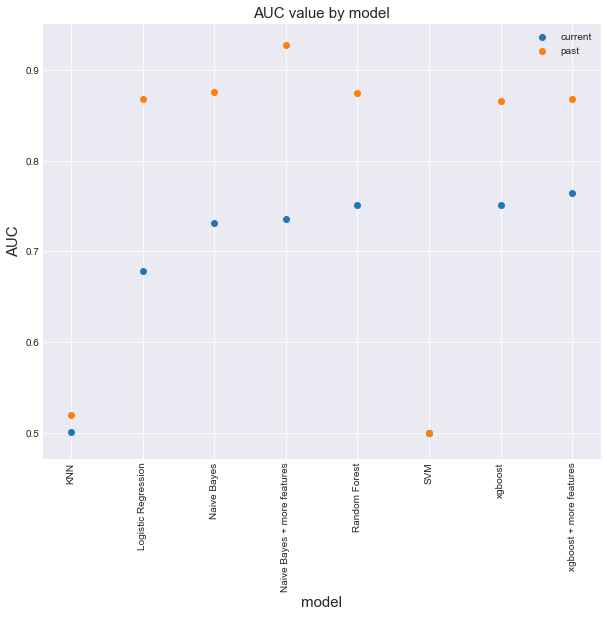

In [145]:

import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
sns.set_style("darkgrid")
plt.xticks(rotation='90')
plt.xlabel('model', fontsize=15)
plt.ylabel('AUC', fontsize=15)
plt.title('AUC value by model', fontsize=15)
p1 = plt.scatter(model_result.model, model_result.current, label="current")
p2 = plt.scatter(model_result.model, model_result.past, label='past')
plt.legend((p1, p2), ('current', 'past'))
plt.show()
